# Tutorial 3: SchNet Arquitecture with PytorchGeometric libraries

La arquitectura SchNet ([K. T. Schütt et al., 2018](https://doi.org/10.1063/1.5019779)) es un tipo de Graph Neural Network (GNN) especifica para modelar sistemas atomisticos, usando como soporte los filtros continuos en capas convolucionales (continuous-filter convolutional layers). Dentro de las aplicaciones que tiene es la de modelar la energia libre (G) dada una configuracion de atomos, esto se puede trabajar de forma equivalente como un problema de regresion numerica donde la variable objetivo sera la energia libre G de una configuracion dada de atomos.

De forma demostrativa se entrenara una arquitectura SchNet usando las libreria PyTorch_geometric usando el dataset QM9, esto requiere los siguientes pasos que se muestran de forma ilustrativa en la siguiente imagen

![](https://github.com/pyF4all/ML4molecularSims/blob/regression/Notebooks/3_SchNet_Pyg/imgs/schnet_pyg.jpg?raw=true)

Paso previo es instalar librerias y importar los modulos necesarios para el entrenamiento

In [ ]:
!pip install torch_geometric
# Pyg cpu libraries
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

In [2]:
import argparse
import os.path as osp
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet
import torch.nn as nn

El dataset QM9 ([Ramakrishnan et al., 2014](https://doi.org/10.1063/1.5019779)) es un dataset usual para hacer un analisis comparativo (benchmarking) entre arquitecturas distintas, contiene la informacion de 134000 moleculas pequeñas compuestas por C,H,O,F y N. Existe una parte de esta total que no esta completamente caracterizada por lo cual se remueven estas y habitualmente se trabaja sobre 130831 moleculas distintas.

Se carga a continuacion el dataset y se muestra la cantidad de features $F$ y variables objetivos (o classes), notar que las classes son estas variables objetivo (target)

| Target | Property                    | Description                                           | Unit         |
|--------|-----------------------------|-------------------------------------------------------|--------------|
| 0      | $\mu$                       | Dipole moment                                         | D            |
| 1      | $\alpha$                    | Isotropic polarizability                              | $a_0^3$      |
| 2      | $\epsilon_{\text{HOMO}}$    | Highest occupied molecular orbital energy             | eV           |
| 3      | $\epsilon_{\text{LUMO}}$    | Lowest unoccupied molecular orbital energy            | eV           |
| 4      | $\Delta \epsilon$           | Gap between $\epsilon_{\text{HOMO}}$ and $\epsilon_{\text{LUMO}}$ | eV           |
| 5      | $\langle R^2 \rangle$       | Electronic spatial extent                             | $a_0^2$      |
| 6      | ZPVE                         | Zero point vibrational energy                         | eV           |
| 7      | $U_0$                       | Internal energy at 0K                                 | eV           |
| 8      | $U$                         | Internal energy at 298.15K                            | eV           |
| 9      | $H$                         | Enthalpy at 298.15K                                   | eV           |
| 10     | $G$                         | Free energy at 298.15K                                | eV           |
| 11     | $c_v$                       | Heat capacity at 298.15K                              | cal/mol·K    |
| 12     | $U_{\text{ATOM}_0}$         | Atomization energy at 0K                              | eV           |
| 13     | $U_{\text{ATOM}}$           | Atomization energy at 298.15K                         | eV           |
| 14     | $H_{\text{ATOM}}$           | Atomization enthalpy at 298.15K                       | eV           |
| 15     | $G_{\text{ATOM}}$           | Atomization free energy at 298.15K                    | eV           |
| 16     | $A$                         | Rotational constant                                   | GHz          |
| 17     | $B$                         | Rotational constant                                   | GHz          |
| 18     | $C$                         | Rotational constant                                   | GHz          |








In [8]:
path = '/content/qm9/'
path = './'
dataset = QM9(path)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./raw/qm9.zip
Processing...
100%|███████████████████████████████████████████████████████████████████| 133885/133885 [01:03<00:00, 2100.26it/s]
Done!


Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19


Una vez cargado el dataset se puede inspeccionar como es cada uno de los grafos que lo componen, en este caso se muestra que variables componen el primer elemento del dataset

Notar que
* La cantidad de nodos (nodes) es variable entre elementos
* No todos los nodos tiene la misma cantidad de enlaces (edges) entre cada uno de los atomos
* La variable $x$ de tamaño $(n \times F)$ contiene los features de cada uno de los nodos, no asi las posiciones que se almacenan en `pos`
* Sobre los enlaces entre nodos se almacenan en la variable `edge_index` donde indica cada una de las conexiones entre nodos $i$ y $j$

Los features hacen referencia a los elementos atomicos, pero agregan variables extras de interes, par mas detalle respecto al dataset, se puede revisar el siguiente enlace ([Gilmer et al., 2017](https://arxiv.org/pdf/1704.01212))



In [9]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


De forma grafica se muestra una molecula del dataset, en este caso la que esta en el indice 121.



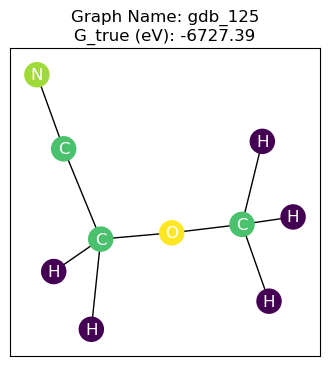

In [10]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
atomic_symbols = {
    1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
    11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
    19: 'K', 20: 'Ca'
}
data = dataset[121]
def visualize_graph(G, data, node_labels):
    plt.figure(figsize=(4,4))
    plt.xticks([])
    plt.yticks([])
    node_colors = data.x.numpy()[:, 5]

    pos = nx.spring_layout(G, seed=42)
    nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(f"Graph Name: {data.name}\nG_true (eV): {np.round(data.y.numpy()[0,10], 2):.2f}")
    plt.show()

# Convertir el gráfico a NetworkX
G = to_networkx(data, to_undirected=True)
# Crear etiquetas para los nodos (usando el número atómico en este caso)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}

visualize_graph(G, data, node_labels)

El entrenamiento funciona de forma similar para cualquier red dentro de PyTorch. En especial se debe considerar los siguientes metodos/ clases

*   `SchNet()` es la clase de PytorchGeometric que contiene la arquitectura [SchNet](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.SchNet.html)
*   `torch.optim.Adam()` es el optimizador tipo Adam para encontrar los pesos de la red
* `nn.MSELoss()` es la implementacion del error cuadratico medio (Mean Square Error). Asi tambien `nn.L1Loss()` es el error medio absoluto (Mean Absolute Error)



In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset, val_dataset, test_dataset = dataset[:3000], dataset[3000:4000], dataset[4000:5000]
target_mean, target_std = train_dataset.mean(target=10), train_dataset.std(target=10)
global target_mean, target_std

net = SchNet() #default parameters
print(net)
model = net.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-3)
loss_mse = nn.MSELoss(reduction='mean')
loss_mae = nn.L1Loss()

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True) #before 100
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=True) #before 100
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True) #before 100


def train(data_loader):
    model.train()
    total_loss_mse, total_loss_mae = 0, 0
    for idx, batch in enumerate(data_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.z, batch.pos, batch.batch)
        norm_vals = (batch.y[:,10]-target_mean)/target_std
        loss = loss_mse(out, norm_vals.unsqueeze(-1))
        loss2 = loss_mae(out, norm_vals.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        total_loss_mse += loss.item()
        total_loss_mae += loss2.item()
    return total_loss_mse / len(data_loader), total_loss_mae / len(data_loader)

def test(data_loader,val=True):
    model.eval()
    total_loss_mse, total_loss_mae = 0, 0
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            batch = batch.to(device)
            out = model(batch.z, batch.pos, batch.batch)
            if val:
                batch.y[:, 10] = (batch.y[:,10]-target_mean)/target_std
            else:
                out = (out*target_std)+target_mean
            loss = loss_mse(out, batch.y[:, 10].unsqueeze(-1))
            loss2 = loss_mae(out, batch.y[:, 10].unsqueeze(-1))
            total_loss_mse += loss.item()
            total_loss_mae += loss2.item()
    return total_loss_mse / len(data_loader), total_loss_mae / len(data_loader)

history = {'train_mse':[], 'val_mse':[], 'train_mae':[], 'val_mae':[]}
for epoch in range(1, 30+1):
    loss_train, loss2_train = train(train_loader)
    loss_val, loss2_val = test(val_loader, val=True)
    history['train_mse'].append(loss_train)
    history['val_mse'].append(loss_val)
    history['train_mae'].append(loss2_train)
    history['val_mae'].append(loss2_val)
    print(f'Epoch: {epoch:03d} Train(MSE) {loss_train:.2e} Val(MSE) {loss_val:.2e} Train(MAE) {loss2_train:.2f} Val(MAE) {loss2_val:.2f}')

    torch.cuda.empty_cache()

loss_test, loss2_test = test(test_loader, val=False)
print(f'Test(MSE) {loss_test:.2e}, Test(MAE) {loss2_test:.2f}')

SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
Epoch: 001 Train(MSE) 1.99e+02 Val(MSE) 3.18e+00 Train(MAE) 9.35 Val(MAE) 1.46
Epoch: 002 Train(MSE) 8.68e+00 Val(MSE) 1.24e+00 Train(MAE) 2.32 Val(MAE) 0.93
Epoch: 003 Train(MSE) 2.12e+00 Val(MSE) 6.29e-01 Train(MAE) 1.22 Val(MAE) 0.68
Epoch: 004 Train(MSE) 7.38e-01 Val(MSE) 4.04e-01 Train(MAE) 0.67 Val(MAE) 0.54
Epoch: 005 Train(MSE) 5.08e-01 Val(MSE) 2.84e-01 Train(MAE) 0.52 Val(MAE) 0.42
Epoch: 006 Train(MSE) 4.15e-01 Val(MSE) 2.87e-01 Train(MAE) 0.44 Val(MAE) 0.39
Epoch: 007 Train(MSE) 3.63e-01 Val(MSE) 2.72e-01 Train(MAE) 0.41 Val(MAE) 0.38
Epoch: 008 Train(MSE) 3.28e-01 Val(MSE) 2.45e-01 Train(MAE) 0.38 Val(MAE) 0.36
Epoch: 009 Train(MSE) 2.98e-01 Val(MSE) 2.39e-01 Train(MAE) 0.36 Val(MAE) 0.36
Epoch: 010 Train(MSE) 2.73e-01 Val(MSE) 2.19e-01 Train(MAE) 0.34 Val(MAE) 0.34
Epoch: 011 Train(MSE) 2.52e-01 Val(MSE) 1.92e-01 Train(MAE) 0.33 Val(MAE) 0.32
Epoch: 012 Train(MSE) 2.31e-01 Val(

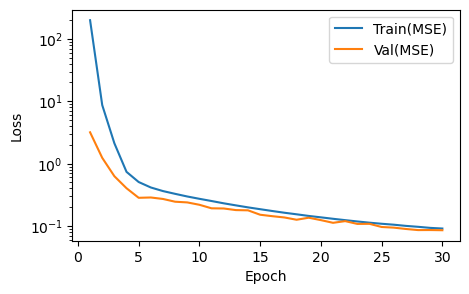

In [43]:
#history = run(num_epochs=10)
plt.figure(figsize=(5,3))
plt.plot(range(1,len(history['train_mse'])+1),history['train_mse'],label='Train(MSE)')
plt.plot(range(1,len(history['val_mse'])+1),history['val_mse'],label='Val(MSE)')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

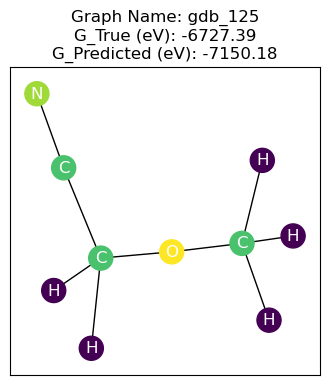

In [41]:
##Testeo
data = dataset[121]
model.eval()
node_colors = data.x.numpy()[:, 5]
predicted_G = model.forward(data.z, data.pos)[0][0].detach().numpy()*target_std+target_mean


plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
G = to_networkx(data, to_undirected=True)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}
pos = nx.spring_layout(G, seed=42)
nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
plt.title(f"Graph Name: {data.name}\nG_True (eV): {data.y.numpy()[0,10]:.2f}\nG_Predicted (eV): {predicted_G:.2f}")
plt.show()


  Como es visible falta seguir un entrenamiento con mas datos dentro de la red, para asi lograr una red con mayor capacidad de generalizacion en el testeo